# Prakhar Jain
# 2022121008

Trained Models : https://drive.google.com/drive/folders/1E1pYtju_sBlSnodKjQa1b_uAq80xNbYN?usp=sharing

In [1]:
# import nltk
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
from preprocess import TextProcessor, Vocabulary, TextDataset
from tqdm.auto import tqdm

import random

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# device = torch.device("cpu")

# 1. Implement the Language Model and report the Perplexity Scores. [40 marks]

In [2]:
file_path = "Auguste_Maquet.txt"
glove_path = "glove.6B.300d.txt"
# can use fasttext as well just by specifying the path

text_processor = TextProcessor(file_path)
sentences = text_processor.preprocess_text()

random.seed(42)
random.shuffle(sentences)

val_len = int(len(sentences) * 0.1)
test_len = int(len(sentences) * 0.2)

train_sentences = sentences[val_len + test_len:]
val_sentences = sentences[:val_len]
test_sentences = sentences[val_len:val_len + test_len]

train_ngrams = text_processor.generate_ngrams(
    train_sentences, 5 + 1)  # 5 for context and 1 for target
val_ngrams = text_processor.generate_ngrams(val_sentences, 5 + 1)
test_ngrams = text_processor.generate_ngrams(test_sentences, 5 + 1)

vocabulary = Vocabulary(glove_path)
vocabulary.build_vocab(train_sentences)
embeddings = vocabulary.get_glove_embeddings()

train_dataset = TextDataset(train_ngrams, vocabulary)
val_dataset = TextDataset(val_ngrams, vocabulary)
test_dataset = TextDataset(test_ngrams, vocabulary)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
print(f"Sentences: {len(sentences)}")

print(f"Train: {len(train_sentences)}")
print(f"Val: {len(val_sentences)}")
print(f"Test: {len(test_sentences)}")

Sentences: 34840
Train: 24388
Val: 3484
Test: 6968


In [4]:
# test functionality
print(train_ngrams[0])

for batch in train_loader:
    for x in batch[0][0]:
        print(vocabulary.index2word(x.item()))
        print(str(x.item()) + " " +
              str(vocabulary.word2index(vocabulary.index2word(x.item()))))

    # print the target word
    print(vocabulary.index2word(batch[1][0].item()))
    print(str(batch[1][0].item()) + " " +
          str(vocabulary.word2index(vocabulary.index2word(batch[1][0].item()))))
    break

<S> copyright laws in most countries
<S>
1 1
copyright
3 3
laws
4 4
in
5 5
most
6 6
countries
7 7


In [5]:
print(embeddings.shape)
print(type(embeddings))

torch.Size([18843, 300])
<class 'torch.Tensor'>


In [2]:
class NeuralLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embedding, dropout):
        super(NeuralLanguageModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(embedding) # freeze param is true by default so the embeddings won't be updated
        self.dropout = dropout

        self.model = nn.Sequential(
            nn.Linear(5 * embedding_dim, 300),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(300, vocab_size)
            # nn.LogSoftmax(dim=1) # CrossEntropyLoss already applies log softmax
        )

    def forward(self, x):
        # x is a tensor of shape (batch_size, 5)
        embeds = self.embedding(x)
        embeds = embeds.view(-1, 5 * self.embedding_dim)  # flatten the tensor
        output = self.model(embeds)
        return output

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

Check out reduction parameter in torch

In [7]:
model = NeuralLanguageModel(
    vocab_size=embeddings.shape[0], embedding_dim=embeddings.shape[1], hidden_dim=300, embedding=embeddings, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [3]:

def calculate_perplexity(loss):
    # perplexity = exp(cross_entropy) this is a direct relationship between cross entropy and perplexity
    return torch.exp(torch.tensor(loss))


def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, leave=False):
        context, target = batch
        context, target = context.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(context)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader.dataset)
    # avg_loss = total_loss / len(train_loader)
    perplexity = calculate_perplexity(avg_loss)
    return avg_loss, perplexity


def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.inference_mode():
        for batch in tqdm(val_loader, leave=False):
            context, target = batch
            context, target = context.to(device), target.to(device)
            output = model(context)
            loss = criterion(output, target)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader.dataset)
    # avg_loss = total_loss / len(val_loader)
    perplexity = calculate_perplexity(avg_loss)
    return avg_loss, perplexity


def test(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.inference_mode():
        for batch in tqdm(test_loader, leave=False):
            context, target = batch
            context, target = context.to(device), target.to(device)
            output = model(context)
            loss = criterion(output, target)
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader.dataset)
    # avg_loss = total_loss / len(test_loader)
    perplexity = calculate_perplexity(avg_loss)
    return avg_loss, perplexity

In [23]:
n_epochs = 10

for epoch in tqdm(range(n_epochs), desc="Epochs", leave=False):
    train_loss, train_perplexity = train_one_epoch(
        model, train_loader, criterion, optimizer)
    val_loss, val_perplexity = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch + 1}/{n_epochs} Train Loss: {train_loss:.4f} Train Perplexity: {
          train_perplexity:.4f} Val Loss: {val_loss:.4f} Val Perplexity: {val_perplexity:.4f}")


test_loss, test_perplexity = test(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} Test Perplexity: {test_perplexity:.4f}")

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 5.9441 Train Perplexity: 381.5087 Val Loss: 5.4403 Val Perplexity: 230.5069


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 5.6128 Train Perplexity: 273.9062 Val Loss: 5.3369 Val Perplexity: 207.8670


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 5.5358 Train Perplexity: 253.6168 Val Loss: 5.3014 Val Perplexity: 200.6216


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 5.4917 Train Perplexity: 242.6768 Val Loss: 5.2832 Val Perplexity: 197.0060


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 5.4582 Train Perplexity: 234.6792 Val Loss: 5.2646 Val Perplexity: 193.3761


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 5.4343 Train Perplexity: 229.1402 Val Loss: 5.2558 Val Perplexity: 191.6668


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 5.4139 Train Perplexity: 224.5009 Val Loss: 5.2464 Val Perplexity: 189.8745


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 5.4029 Train Perplexity: 222.0408 Val Loss: 5.2515 Val Perplexity: 190.8467


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 5.3915 Train Perplexity: 219.5379 Val Loss: 5.2323 Val Perplexity: 187.2212


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 5.3819 Train Perplexity: 217.4456 Val Loss: 5.2498 Val Perplexity: 190.5270


  0%|          | 0/3155 [00:00<?, ?it/s]

Test Loss: 5.2400 Test Perplexity: 188.6686


In [24]:
# save the model
torch.save(model.state_dict(), "model.pth")

# 2. **Bonus** Plot graphs showing the variation of average train/test perplexities with varying hyperparameters  like Dropout rate, changing the dimensions of the layers, changing the Optimizer, etc. Report the most optimal Hyperparameters found. [10 marks]

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.4297 Train Perplexity: 228.0699 Val Loss: 5.1140 Val Perplexity: 166.3285


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 4.9690 Train Perplexity: 143.8760 Val Loss: 5.0375 Val Perplexity: 154.0913


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 4.8631 Train Perplexity: 129.4249 Val Loss: 5.0402 Val Perplexity: 154.4943


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 4.8185 Train Perplexity: 123.7848 Val Loss: 5.0572 Val Perplexity: 157.1428


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 4.7891 Train Perplexity: 120.1898 Val Loss: 5.0889 Val Perplexity: 162.2143


  0%|          | 0/3155 [00:00<?, ?it/s]

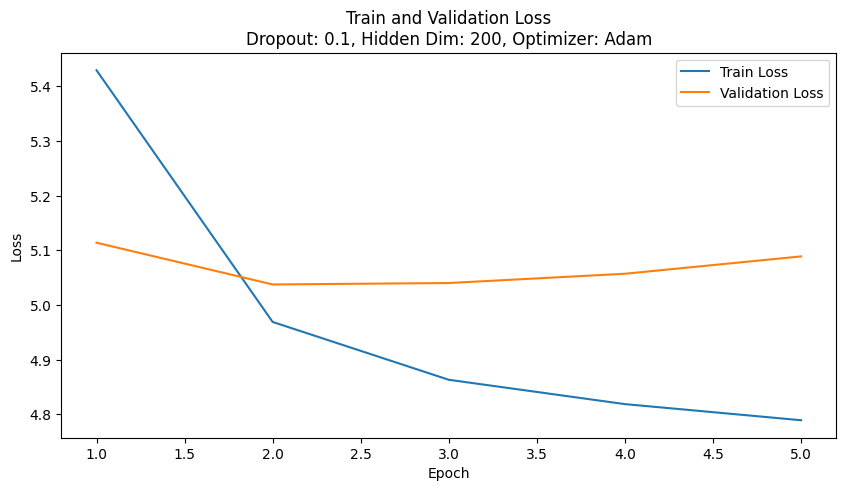

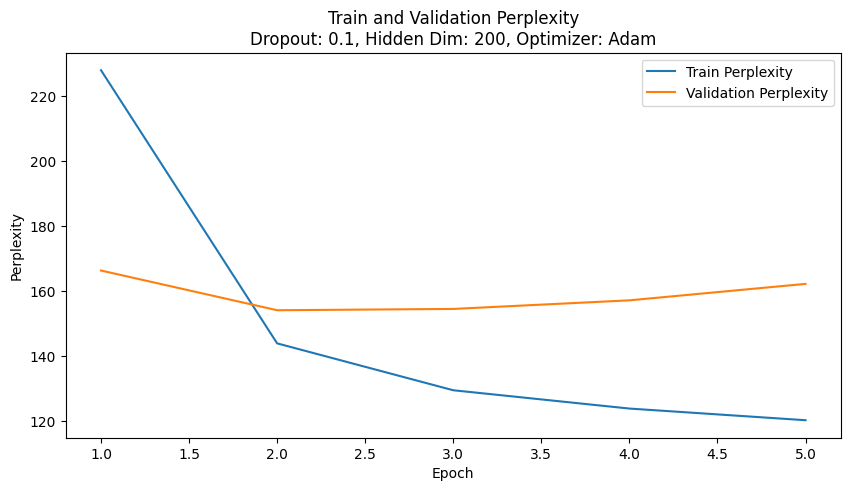

Dropout: 0.1, Hidden Dim: 200, Optimizer: Adam, Train Perplexity: 120.1898422241211, Test Perplexity: 162.76153564453125


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.5447 Train Perplexity: 255.8827 Val Loss: 5.1561 Val Perplexity: 173.4896


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 5.0352 Train Perplexity: 153.7364 Val Loss: 4.9524 Val Perplexity: 141.5162


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 4.8559 Train Perplexity: 128.4936 Val Loss: 4.8524 Val Perplexity: 128.0524


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 4.7380 Train Perplexity: 114.2077 Val Loss: 4.7883 Val Perplexity: 120.0969


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 4.6463 Train Perplexity: 104.1940 Val Loss: 4.7457 Val Perplexity: 115.0887


  0%|          | 0/3155 [00:00<?, ?it/s]

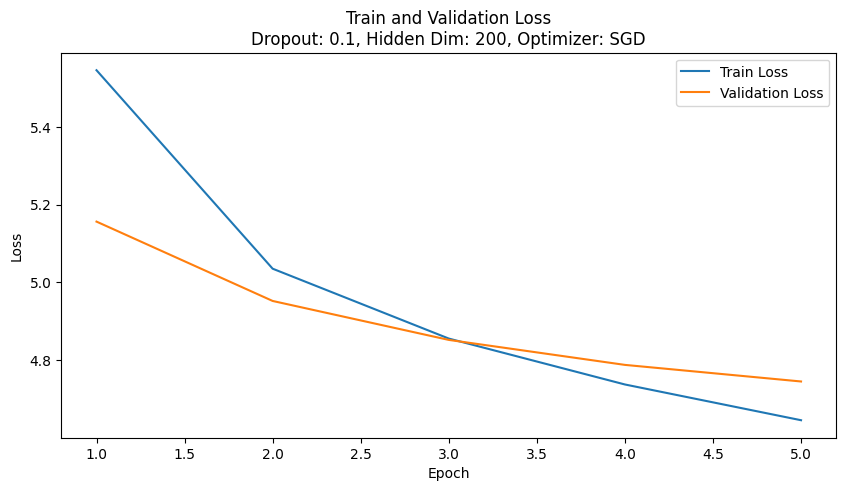

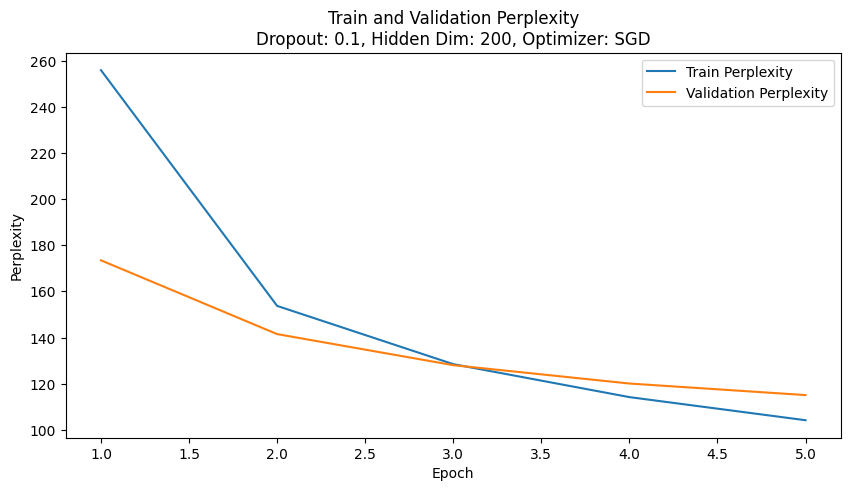

Dropout: 0.1, Hidden Dim: 200, Optimizer: SGD, Train Perplexity: 104.19404602050781, Test Perplexity: 114.15992736816406


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.4331 Train Perplexity: 228.8621 Val Loss: 5.1113 Val Perplexity: 165.8928


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 4.9687 Train Perplexity: 143.8353 Val Loss: 5.0481 Val Perplexity: 155.7310


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 4.8648 Train Perplexity: 129.6411 Val Loss: 5.0425 Val Perplexity: 154.8625


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 4.8190 Train Perplexity: 123.8430 Val Loss: 5.0576 Val Perplexity: 157.2072


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 4.7892 Train Perplexity: 120.1998 Val Loss: 5.0811 Val Perplexity: 160.9574


  0%|          | 0/3155 [00:00<?, ?it/s]

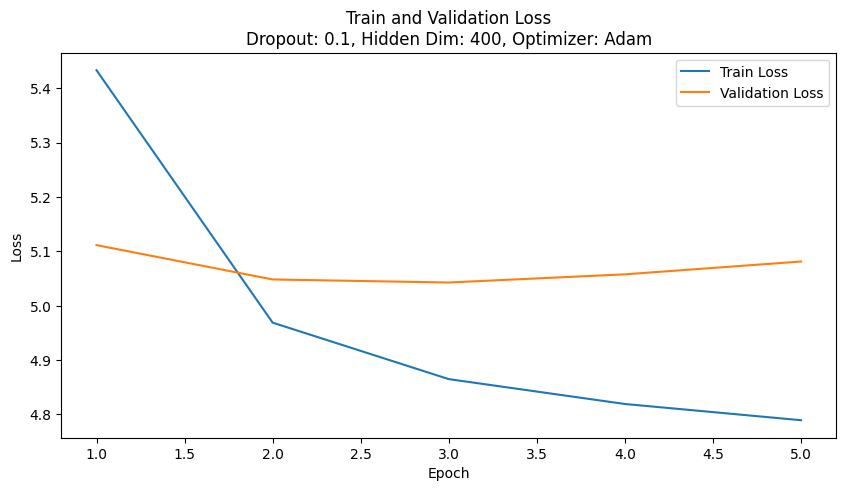

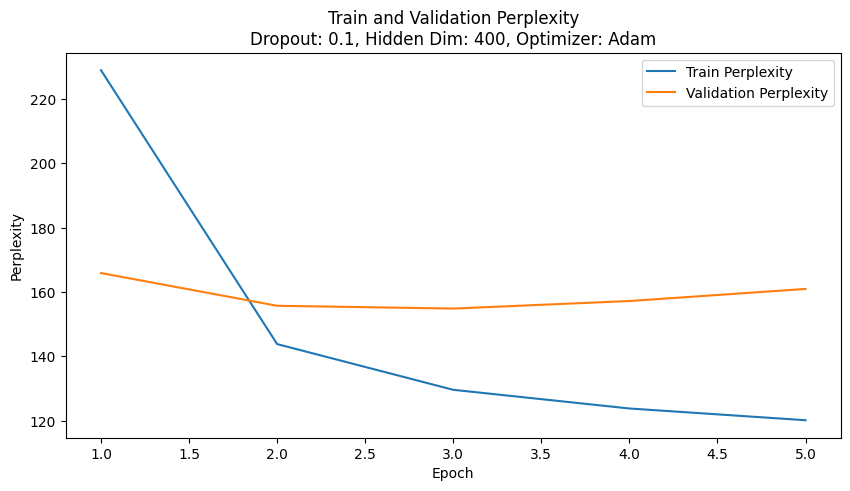

Dropout: 0.1, Hidden Dim: 400, Optimizer: Adam, Train Perplexity: 120.19976043701172, Test Perplexity: 160.866455078125


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.5446 Train Perplexity: 255.8427 Val Loss: 5.1542 Val Perplexity: 173.1534


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 5.0339 Train Perplexity: 153.5273 Val Loss: 4.9548 Val Perplexity: 141.8505


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 4.8545 Train Perplexity: 128.3194 Val Loss: 4.8530 Val Perplexity: 128.1266


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 4.7364 Train Perplexity: 114.0215 Val Loss: 4.7913 Val Perplexity: 120.4594


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 4.6456 Train Perplexity: 104.1228 Val Loss: 4.7511 Val Perplexity: 115.7101


  0%|          | 0/3155 [00:00<?, ?it/s]

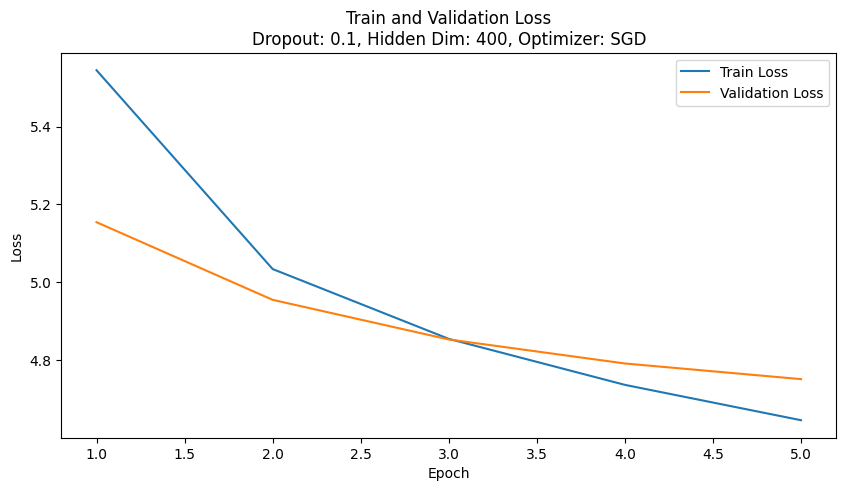

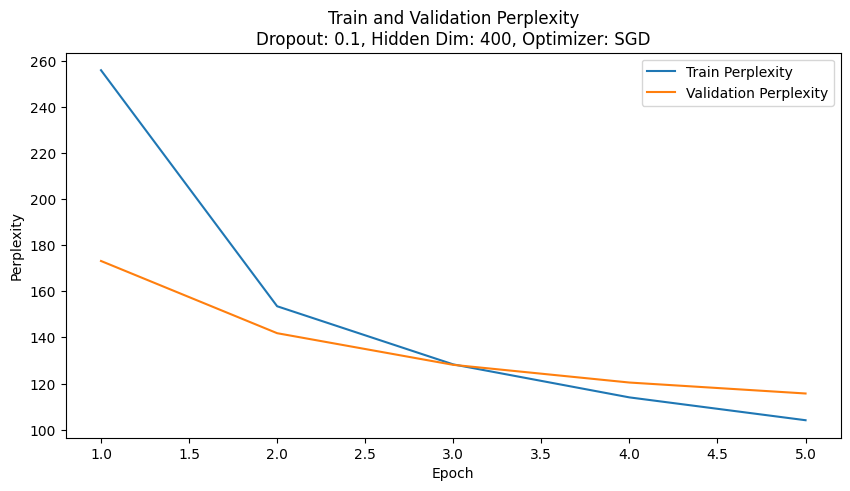

Dropout: 0.1, Hidden Dim: 400, Optimizer: SGD, Train Perplexity: 104.1227798461914, Test Perplexity: 114.83517456054688


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.4260 Train Perplexity: 227.2282 Val Loss: 5.1060 Val Perplexity: 165.0173


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 4.9623 Train Perplexity: 142.9150 Val Loss: 5.0437 Val Perplexity: 155.0350


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 4.8562 Train Perplexity: 128.5404 Val Loss: 5.0359 Val Perplexity: 153.8304


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 4.8089 Train Perplexity: 122.6023 Val Loss: 5.0523 Val Perplexity: 156.3868


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 4.7820 Train Perplexity: 119.3417 Val Loss: 5.0798 Val Perplexity: 160.7406


  0%|          | 0/3155 [00:00<?, ?it/s]

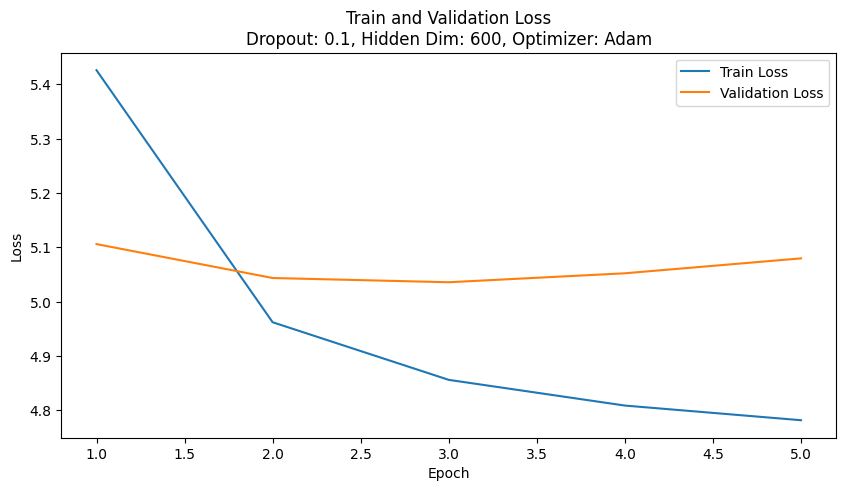

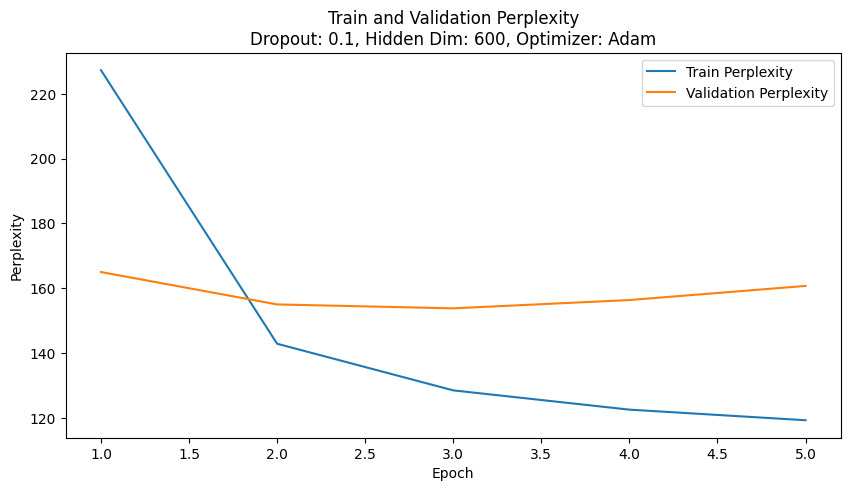

Dropout: 0.1, Hidden Dim: 600, Optimizer: Adam, Train Perplexity: 119.34166717529297, Test Perplexity: 160.1875762939453


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.5483 Train Perplexity: 256.8107 Val Loss: 5.1546 Val Perplexity: 173.2320


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 5.0375 Train Perplexity: 154.0845 Val Loss: 4.9566 Val Perplexity: 142.1087


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 4.8584 Train Perplexity: 128.8134 Val Loss: 4.8563 Val Perplexity: 128.5530


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 4.7404 Train Perplexity: 114.4820 Val Loss: 4.7945 Val Perplexity: 120.8410


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 4.6492 Train Perplexity: 104.5057 Val Loss: 4.7505 Val Perplexity: 115.6397


  0%|          | 0/3155 [00:00<?, ?it/s]

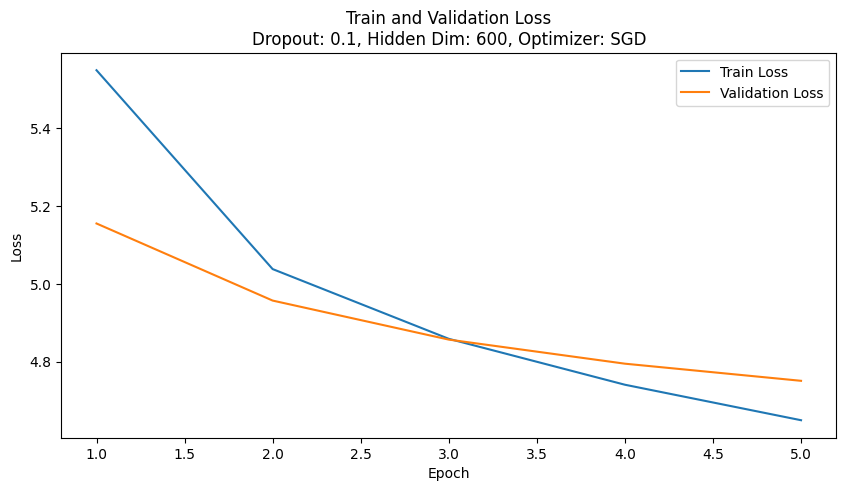

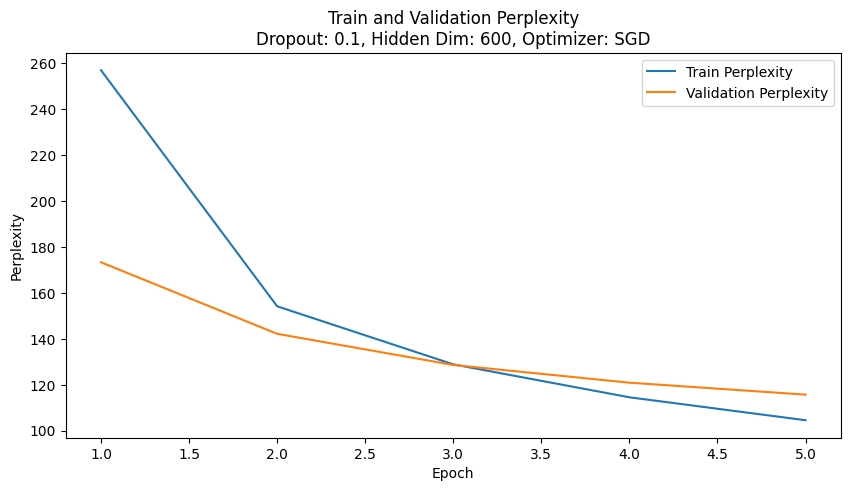

Dropout: 0.1, Hidden Dim: 600, Optimizer: SGD, Train Perplexity: 104.50568389892578, Test Perplexity: 114.58646392822266


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.6535 Train Perplexity: 285.2843 Val Loss: 5.2508 Val Perplexity: 190.7124


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 5.2659 Train Perplexity: 193.6234 Val Loss: 5.1429 Val Perplexity: 171.2145


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 5.1887 Train Perplexity: 179.2324 Val Loss: 5.1092 Val Perplexity: 165.5338


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 5.1528 Train Perplexity: 172.9207 Val Loss: 5.1074 Val Perplexity: 165.2372


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 5.1340 Train Perplexity: 169.6919 Val Loss: 5.1097 Val Perplexity: 165.6205


  0%|          | 0/3155 [00:00<?, ?it/s]

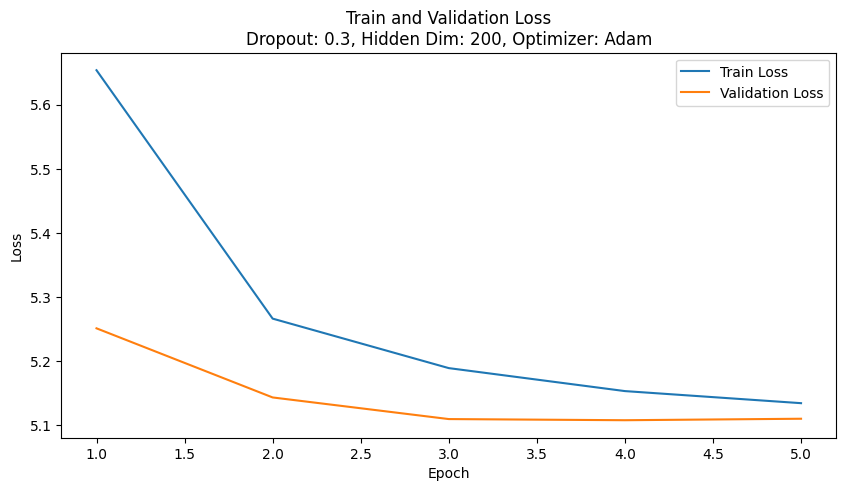

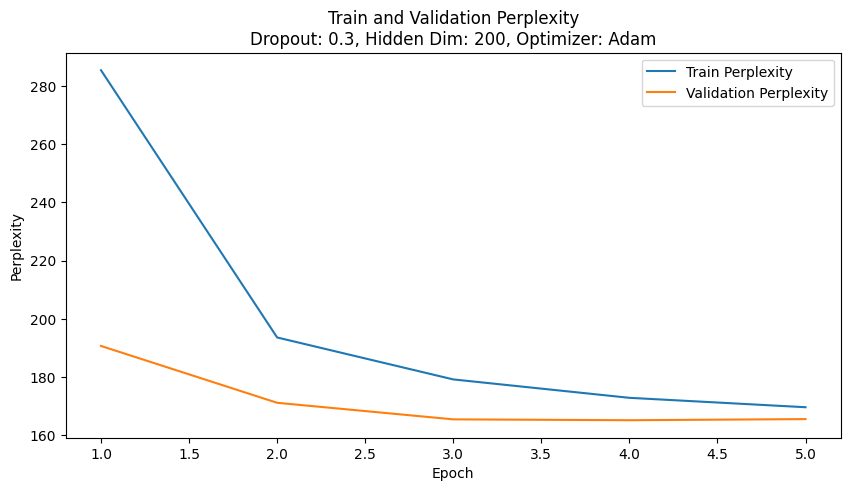

Dropout: 0.3, Hidden Dim: 200, Optimizer: Adam, Train Perplexity: 169.69192504882812, Test Perplexity: 164.9333953857422


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.6131 Train Perplexity: 273.9830 Val Loss: 5.1851 Val Perplexity: 178.5916


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 5.1193 Train Perplexity: 167.2250 Val Loss: 4.9847 Val Perplexity: 146.1560


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 4.9550 Train Perplexity: 141.8796 Val Loss: 4.8853 Val Perplexity: 132.3320


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 4.8505 Train Perplexity: 127.7990 Val Loss: 4.8205 Val Perplexity: 124.0310


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 4.7702 Train Perplexity: 117.9395 Val Loss: 4.7754 Val Perplexity: 118.5630


  0%|          | 0/3155 [00:00<?, ?it/s]

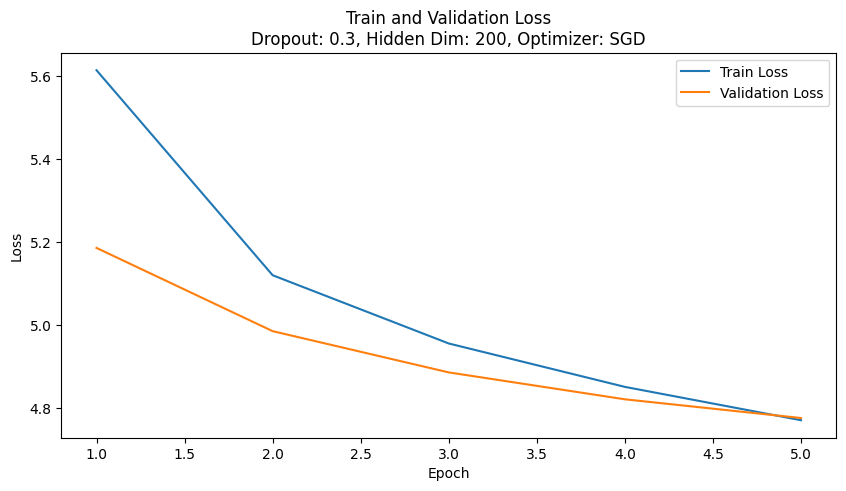

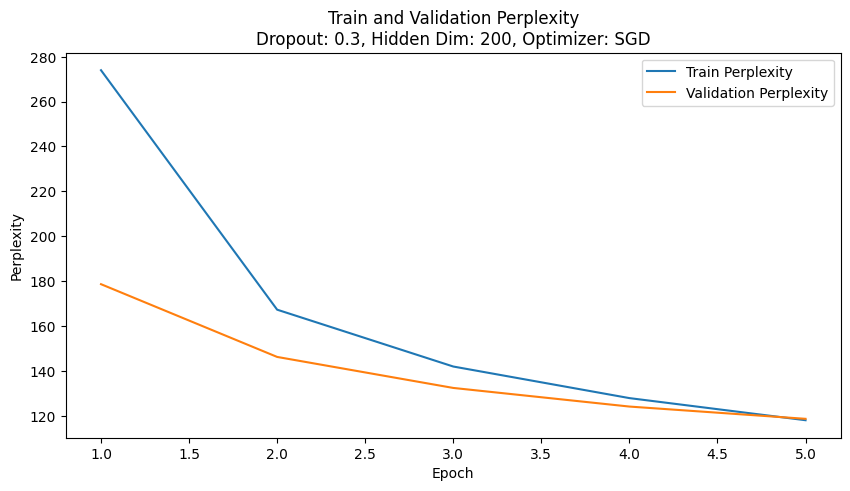

Dropout: 0.3, Hidden Dim: 200, Optimizer: SGD, Train Perplexity: 117.93948364257812, Test Perplexity: 117.59210968017578


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.6546 Train Perplexity: 285.6070 Val Loss: 5.2342 Val Perplexity: 187.5794


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 5.2716 Train Perplexity: 194.7241 Val Loss: 5.1215 Val Perplexity: 167.5918


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 5.1884 Train Perplexity: 179.1770 Val Loss: 5.1024 Val Perplexity: 164.4196


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 5.1549 Train Perplexity: 173.2817 Val Loss: 5.0993 Val Perplexity: 163.9063


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 5.1336 Train Perplexity: 169.6254 Val Loss: 5.1054 Val Perplexity: 164.9105


  0%|          | 0/3155 [00:00<?, ?it/s]

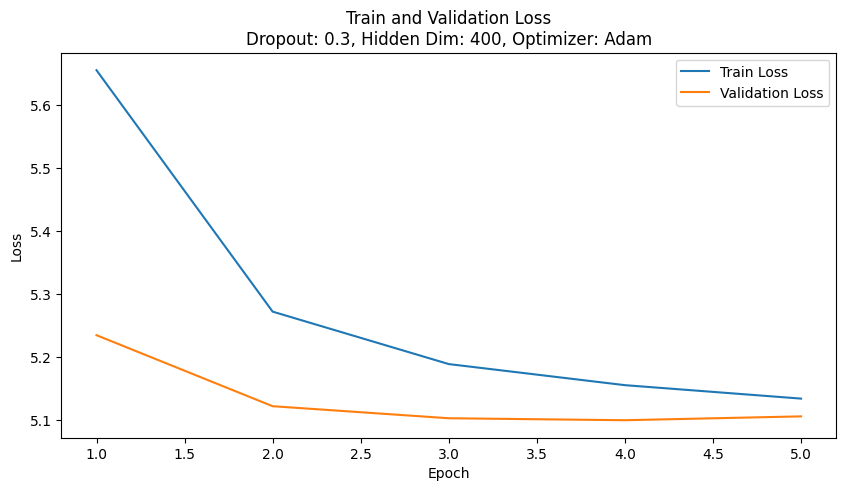

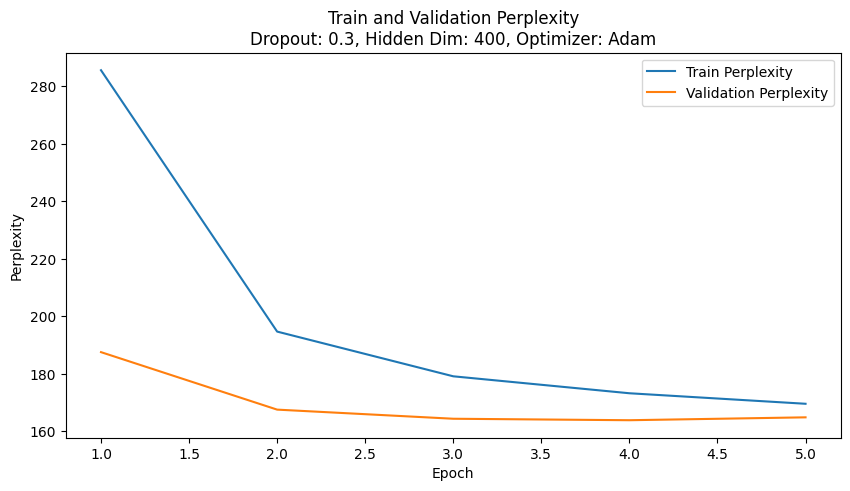

Dropout: 0.3, Hidden Dim: 400, Optimizer: Adam, Train Perplexity: 169.62542724609375, Test Perplexity: 165.78701782226562


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.6185 Train Perplexity: 275.4719 Val Loss: 5.1842 Val Perplexity: 178.4298


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 5.1218 Train Perplexity: 167.6359 Val Loss: 4.9822 Val Perplexity: 145.8002


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 4.9581 Train Perplexity: 142.3164 Val Loss: 4.8817 Val Perplexity: 131.8548


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 4.8515 Train Perplexity: 127.9312 Val Loss: 4.8190 Val Perplexity: 123.8375


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 4.7717 Train Perplexity: 118.1196 Val Loss: 4.7726 Val Perplexity: 118.2216


  0%|          | 0/3155 [00:00<?, ?it/s]

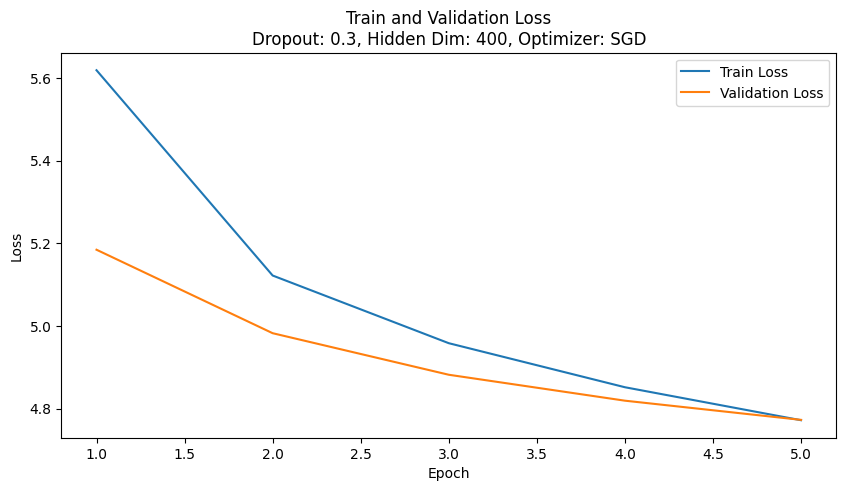

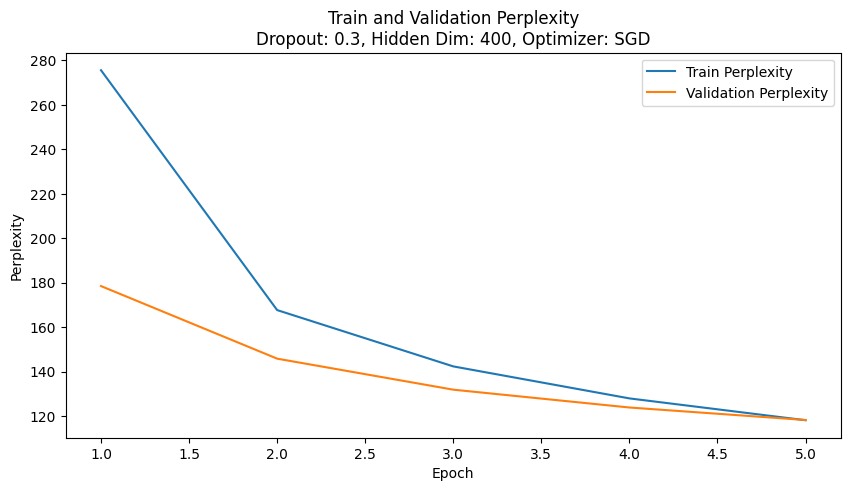

Dropout: 0.3, Hidden Dim: 400, Optimizer: SGD, Train Perplexity: 118.11963653564453, Test Perplexity: 117.10568237304688


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.6507 Train Perplexity: 284.5022 Val Loss: 5.2313 Val Perplexity: 187.0368


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 5.2629 Train Perplexity: 193.0383 Val Loss: 5.1354 Val Perplexity: 169.9245


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 5.1869 Train Perplexity: 178.9127 Val Loss: 5.1269 Val Perplexity: 168.4958


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 5.1526 Train Perplexity: 172.8853 Val Loss: 5.1214 Val Perplexity: 167.5774


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 5.1355 Train Perplexity: 169.9495 Val Loss: 5.1272 Val Perplexity: 168.5441


  0%|          | 0/3155 [00:00<?, ?it/s]

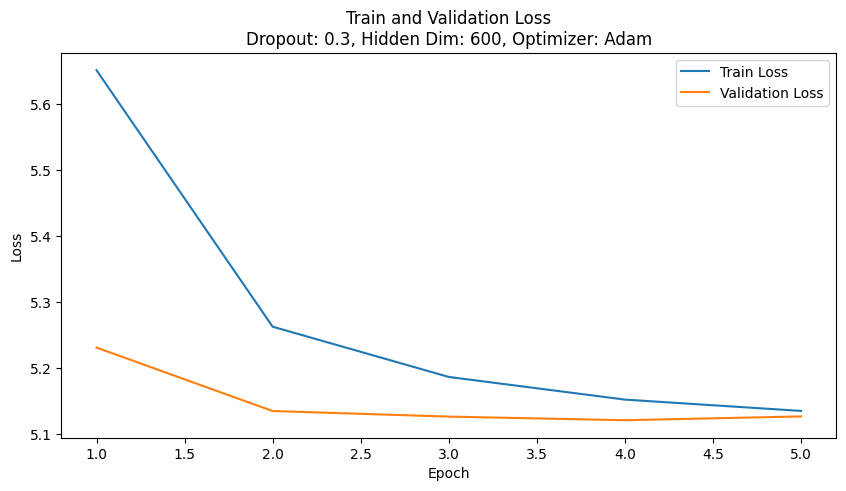

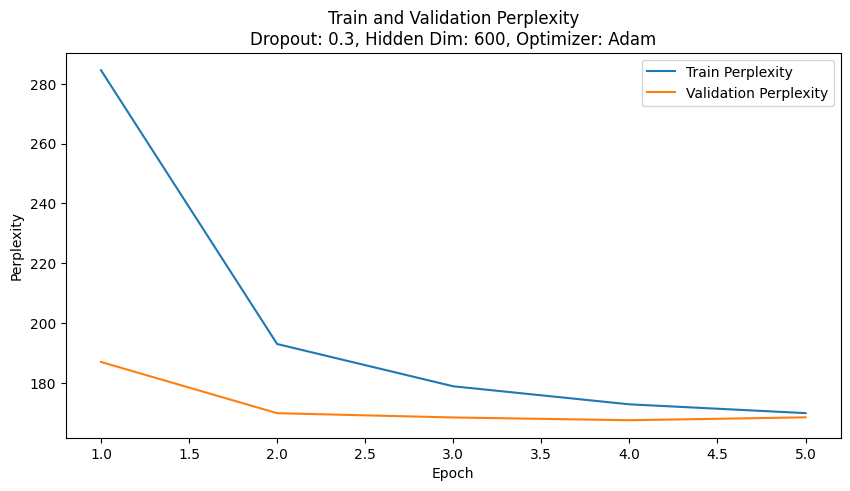

Dropout: 0.3, Hidden Dim: 600, Optimizer: Adam, Train Perplexity: 169.9495086669922, Test Perplexity: 167.6457061767578


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.6145 Train Perplexity: 274.3762 Val Loss: 5.1842 Val Perplexity: 178.4341


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 5.1208 Train Perplexity: 167.4627 Val Loss: 4.9850 Val Perplexity: 146.2007


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 4.9577 Train Perplexity: 142.2713 Val Loss: 4.8824 Val Perplexity: 131.9425


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 4.8524 Train Perplexity: 128.0421 Val Loss: 4.8216 Val Perplexity: 124.1574


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 4.7741 Train Perplexity: 118.4055 Val Loss: 4.7751 Val Perplexity: 118.5164


  0%|          | 0/3155 [00:00<?, ?it/s]

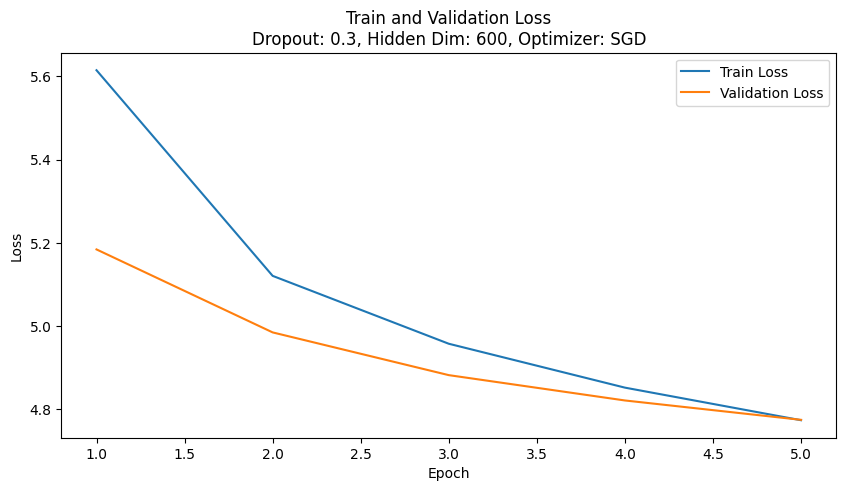

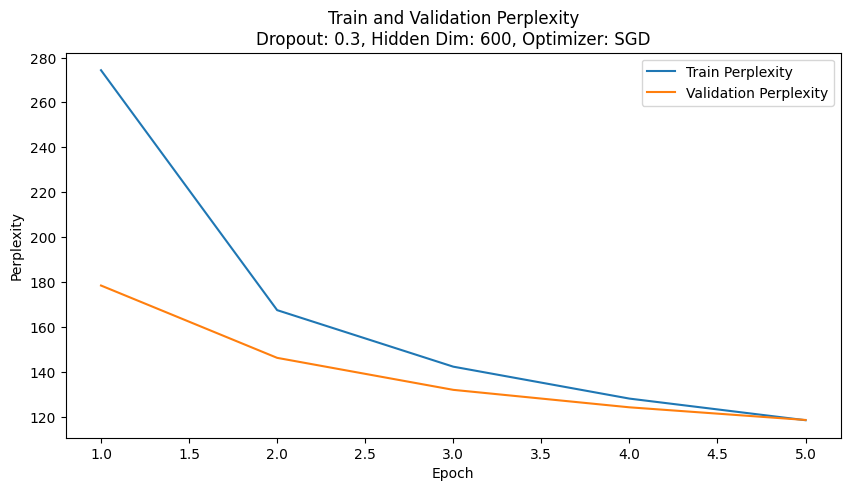

Dropout: 0.3, Hidden Dim: 600, Optimizer: SGD, Train Perplexity: 118.40554809570312, Test Perplexity: 117.49833679199219


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.9408 Train Perplexity: 380.2516 Val Loss: 5.4341 Val Perplexity: 229.0822


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 5.6155 Train Perplexity: 274.6433 Val Loss: 5.3148 Val Perplexity: 203.3296


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 5.5360 Train Perplexity: 253.6738 Val Loss: 5.2659 Val Perplexity: 193.6244


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 5.4906 Train Perplexity: 242.4092 Val Loss: 5.2470 Val Perplexity: 189.9937


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 5.4542 Train Perplexity: 233.7427 Val Loss: 5.2428 Val Perplexity: 189.1904


  0%|          | 0/3155 [00:00<?, ?it/s]

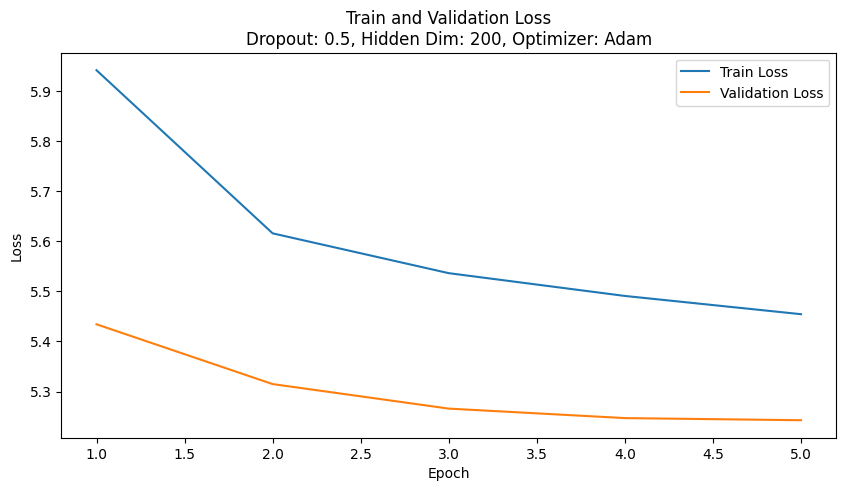

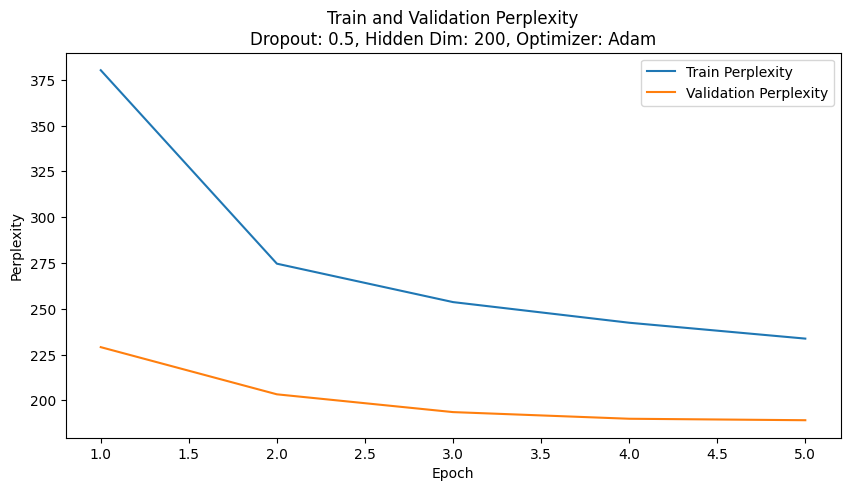

Dropout: 0.5, Hidden Dim: 200, Optimizer: Adam, Train Perplexity: 233.74266052246094, Test Perplexity: 188.671142578125


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.7049 Train Perplexity: 300.3211 Val Loss: 5.2264 Val Perplexity: 186.1167


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 5.2293 Train Perplexity: 186.6675 Val Loss: 5.0299 Val Perplexity: 152.9236


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 5.0781 Train Perplexity: 160.4681 Val Loss: 4.9299 Val Perplexity: 138.3629


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 4.9844 Train Perplexity: 146.1190 Val Loss: 4.8653 Val Perplexity: 129.7105


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 4.9142 Train Perplexity: 136.2042 Val Loss: 4.8201 Val Perplexity: 123.9768


  0%|          | 0/3155 [00:00<?, ?it/s]

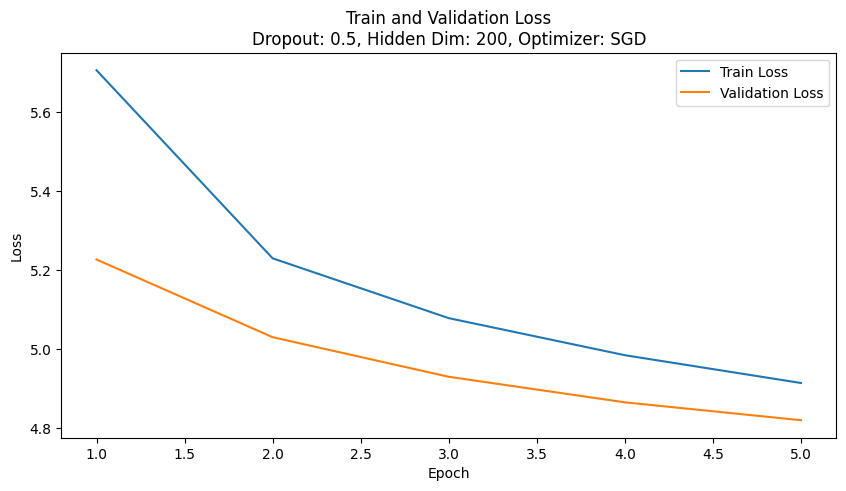

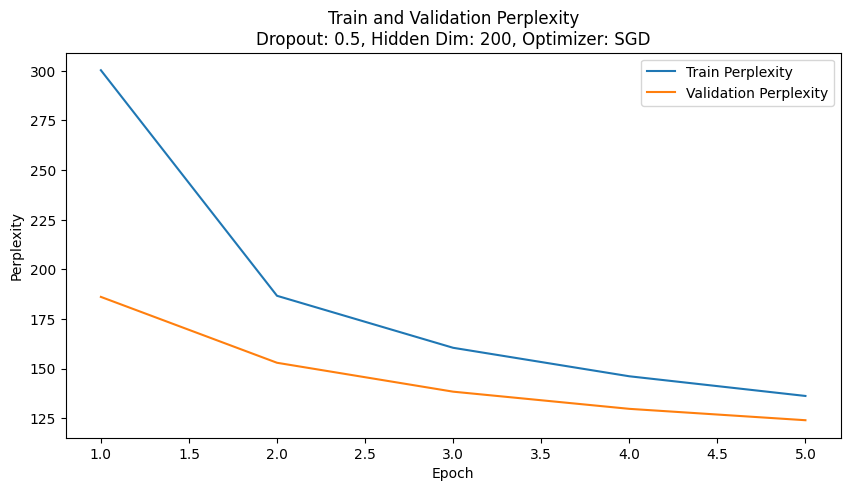

Dropout: 0.5, Hidden Dim: 200, Optimizer: SGD, Train Perplexity: 136.20416259765625, Test Perplexity: 123.0960464477539


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.9371 Train Perplexity: 378.8175 Val Loss: 5.4183 Val Perplexity: 225.5041


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 5.6060 Train Perplexity: 272.0455 Val Loss: 5.2985 Val Perplexity: 200.0290


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 5.5244 Train Perplexity: 250.7293 Val Loss: 5.2541 Val Perplexity: 191.3450


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 5.4778 Train Perplexity: 239.3127 Val Loss: 5.2383 Val Perplexity: 188.3562


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 5.4506 Train Perplexity: 232.8970 Val Loss: 5.2229 Val Perplexity: 185.4626


  0%|          | 0/3155 [00:00<?, ?it/s]

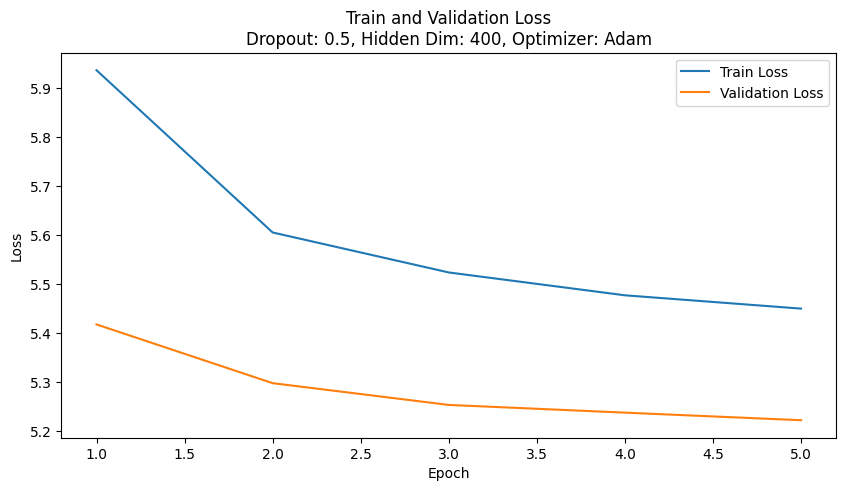

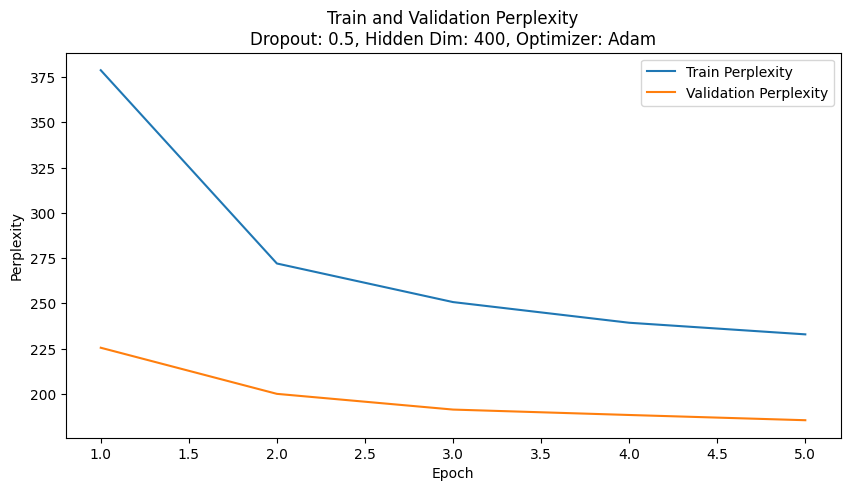

Dropout: 0.5, Hidden Dim: 400, Optimizer: Adam, Train Perplexity: 232.89700317382812, Test Perplexity: 185.0775909423828


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.7198 Train Perplexity: 304.8378 Val Loss: 5.2287 Val Perplexity: 186.5535


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 5.2374 Train Perplexity: 188.1856 Val Loss: 5.0332 Val Perplexity: 153.4303


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 5.0836 Train Perplexity: 161.3482 Val Loss: 4.9320 Val Perplexity: 138.6631


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 4.9856 Train Perplexity: 146.2848 Val Loss: 4.8631 Val Perplexity: 129.4244


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 4.9150 Train Perplexity: 136.3231 Val Loss: 4.8222 Val Perplexity: 124.2370


  0%|          | 0/3155 [00:00<?, ?it/s]

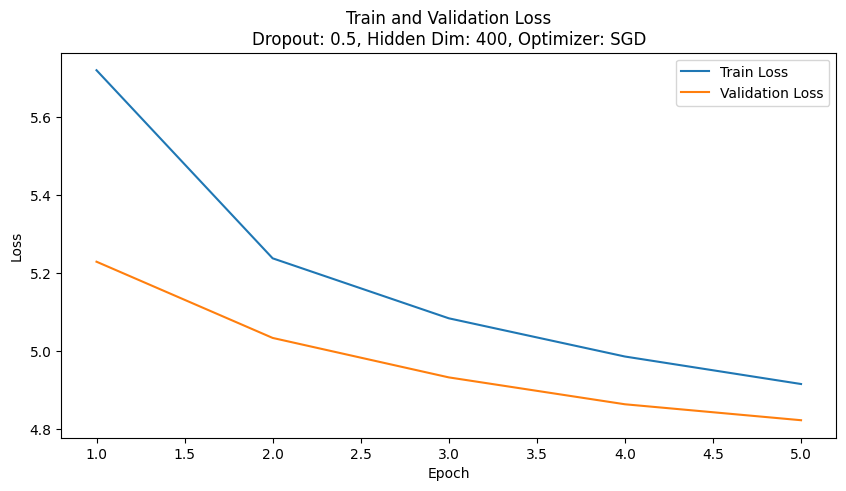

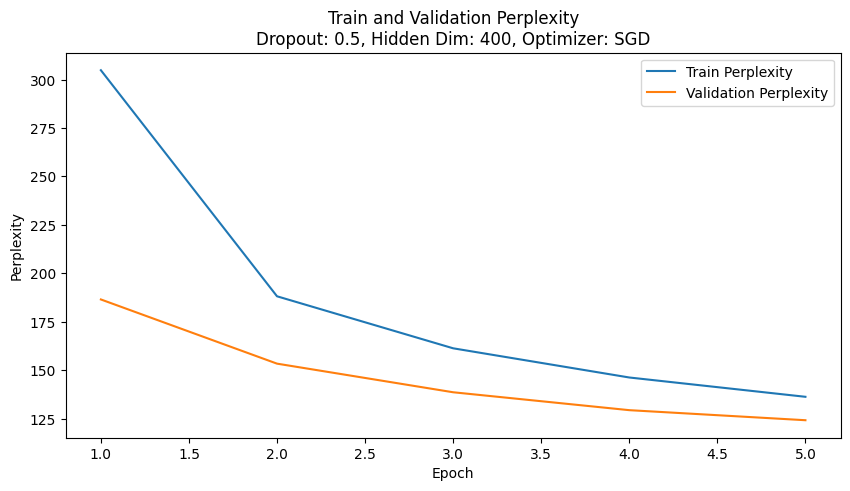

Dropout: 0.5, Hidden Dim: 400, Optimizer: SGD, Train Perplexity: 136.32313537597656, Test Perplexity: 123.3853530883789


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.9382 Train Perplexity: 379.2339 Val Loss: 5.4165 Val Perplexity: 225.0865


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 5.6099 Train Perplexity: 273.1032 Val Loss: 5.3061 Val Perplexity: 201.5547


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 5.5319 Train Perplexity: 252.6163 Val Loss: 5.2801 Val Perplexity: 196.3907


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 5.4815 Train Perplexity: 240.1954 Val Loss: 5.2295 Val Perplexity: 186.6970


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 5.4491 Train Perplexity: 232.5544 Val Loss: 5.2240 Val Perplexity: 185.6749


  0%|          | 0/3155 [00:00<?, ?it/s]

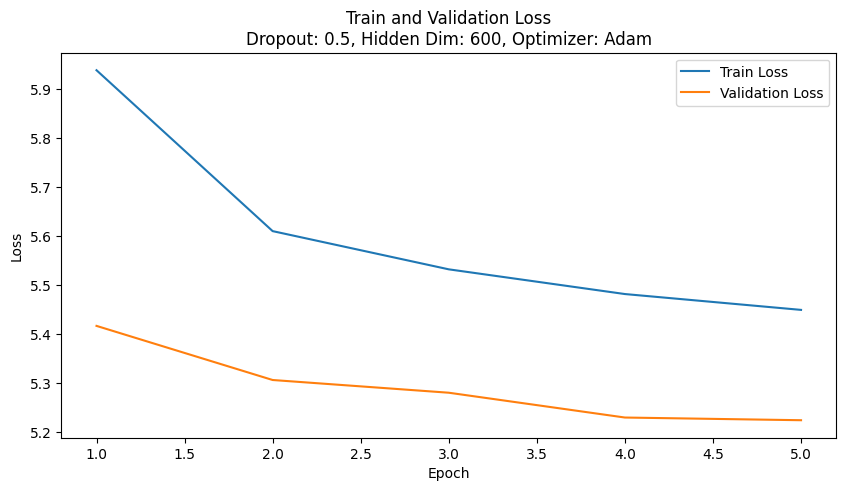

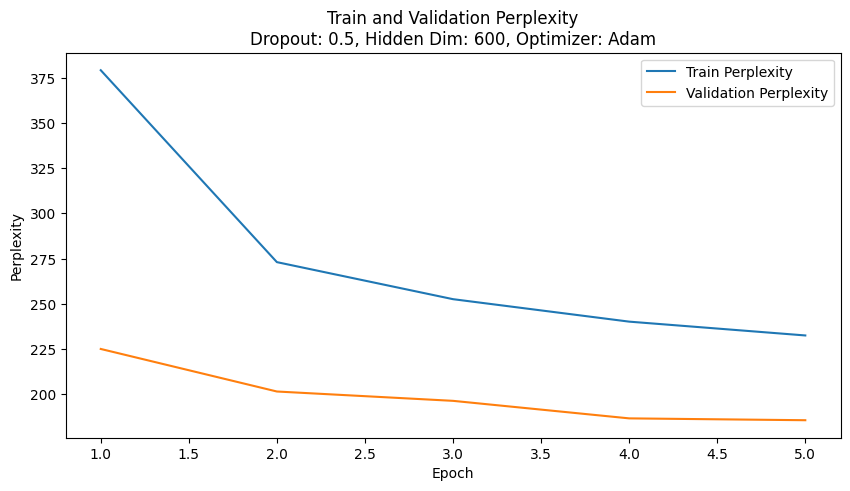

Dropout: 0.5, Hidden Dim: 600, Optimizer: Adam, Train Perplexity: 232.554443359375, Test Perplexity: 185.63148498535156


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 1/5 Train Loss: 5.7040 Train Perplexity: 300.0658 Val Loss: 5.2239 Val Perplexity: 185.6592


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 2/5 Train Loss: 5.2263 Train Perplexity: 186.1042 Val Loss: 5.0299 Val Perplexity: 152.9107


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 3/5 Train Loss: 5.0725 Train Perplexity: 159.5723 Val Loss: 4.9265 Val Perplexity: 137.9013


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 4/5 Train Loss: 4.9780 Train Perplexity: 145.1777 Val Loss: 4.8622 Val Perplexity: 129.3130


  0%|          | 0/11037 [00:00<?, ?it/s]

  0%|          | 0/1579 [00:00<?, ?it/s]

Epoch 5/5 Train Loss: 4.9073 Train Perplexity: 135.2798 Val Loss: 4.8168 Val Perplexity: 123.5685


  0%|          | 0/3155 [00:00<?, ?it/s]

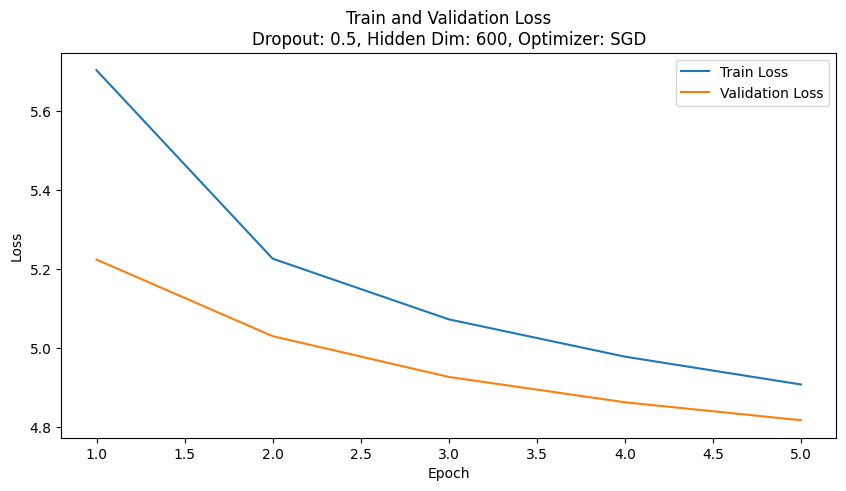

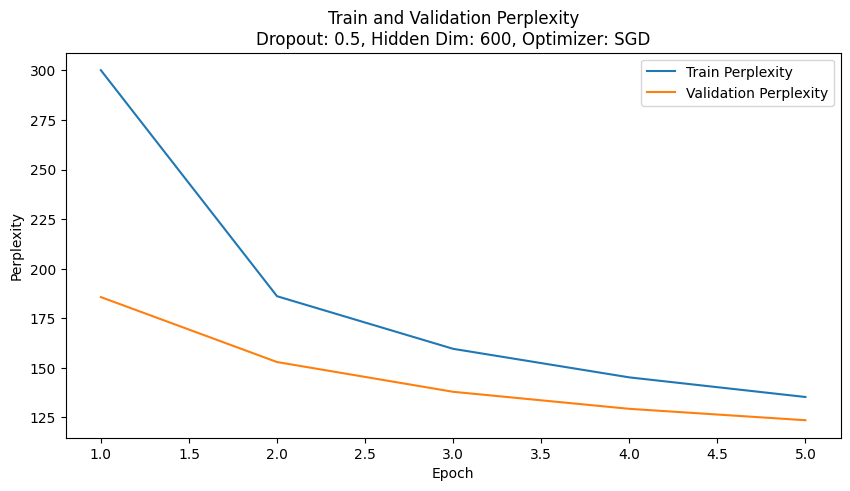

Dropout: 0.5, Hidden Dim: 600, Optimizer: SGD, Train Perplexity: 135.27981567382812, Test Perplexity: 122.59082794189453


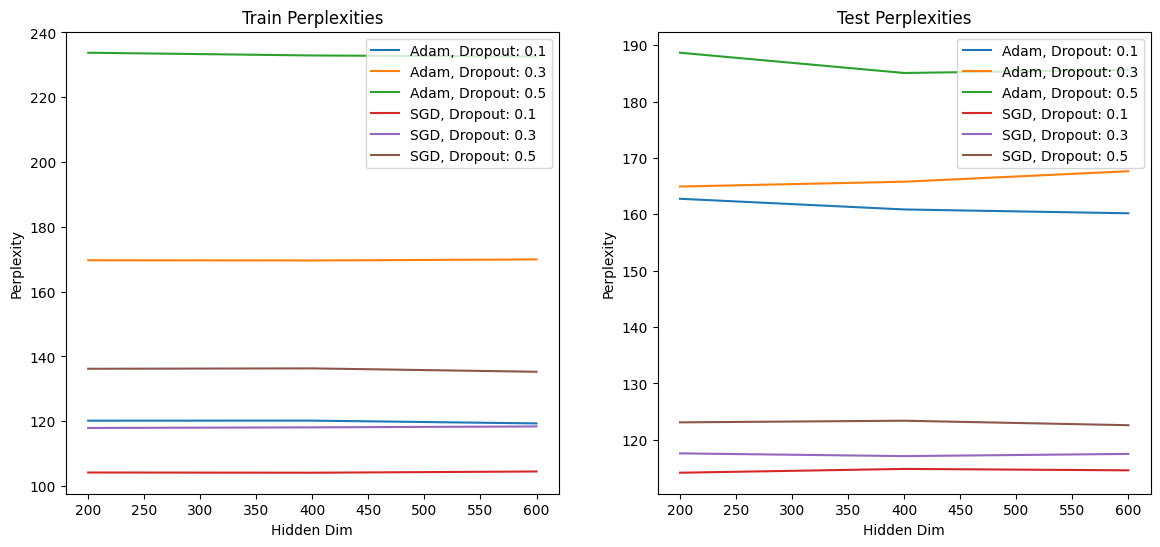

Optimal Hyperparameters: Dropout: 0.1, Hidden Dim: 200, Optimizer: SGD, Test Perplexity: 114.15992736816406


In [9]:
import matplotlib.pyplot as plt

# Define hyperparameter ranges
dropout_rates = [0.1, 0.3, 0.5]
hidden_dims = [200, 400, 600]
optimizers = ['Adam', 'SGD']

# Function to get optimizer


def get_optimizer(optimizer_name, model_params, lr=0.001, weight_decay=0):
    if optimizer_name == 'Adam':
        return optim.Adam(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        return optim.SGD(model_params, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

# Function to train and evaluate the model


def train_and_evaluate(dropout, hidden_dim, optimizer_name):
    model = NeuralLanguageModel(
        vocab_size=embeddings.shape[0], embedding_dim=embeddings.shape[1], hidden_dim=hidden_dim, embedding=embeddings, dropout=dropout)
    criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = get_optimizer(
        optimizer_name, model.parameters(), lr=0.001, weight_decay=1e-5)
    model.to(device)

    n_epochs = 5
    train_losses = []
    val_losses = []
    train_perplexities = []
    val_perplexities = []

    for epoch in tqdm(range(n_epochs), desc="Epochs", leave=False):
        train_loss, train_perplexity = train_one_epoch(
            model, train_loader, criterion, optimizer)
        val_loss, val_perplexity = evaluate(model, val_loader, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_perplexities.append(train_perplexity)
        val_perplexities.append(val_perplexity)
        print(f"Epoch {epoch + 1}/{n_epochs} Train Loss: {train_loss:.4f} Train Perplexity: {
              train_perplexity:.4f} Val Loss: {val_loss:.4f} Val Perplexity: {val_perplexity:.4f}")

    test_loss, test_perplexity = test(model, test_loader, criterion)

    # Plot train and validation loss for each epoch
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train and Validation Loss\nDropout: {dropout}, Hidden Dim: {
              hidden_dim}, Optimizer: {optimizer_name}')
    plt.legend()
    plt.show()

    # Plot train and validation perplexity for each epoch
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_epochs + 1), train_perplexities,
             label='Train Perplexity')
    plt.plot(range(1, n_epochs + 1), val_perplexities,
             label='Validation Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title(f'Train and Validation Perplexity\nDropout: {
              dropout}, Hidden Dim: {hidden_dim}, Optimizer: {optimizer_name}')
    plt.legend()
    plt.show()

    return train_perplexity, test_perplexity


results = []

for dropout in dropout_rates:
    for hidden_dim in hidden_dims:
        for optimizer_name in optimizers:
            train_perplexity, test_perplexity = train_and_evaluate(
                dropout, hidden_dim, optimizer_name)
            results.append((dropout, hidden_dim, optimizer_name,
                           train_perplexity, test_perplexity))
            print(f"Dropout: {dropout}, Hidden Dim: {hidden_dim}, Optimizer: {
                  optimizer_name}, Train Perplexity: {train_perplexity}, Test Perplexity: {test_perplexity}")

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

for optimizer_name in optimizers:
    for dropout in dropout_rates:
        train_perplexities = [
            res[3] for res in results if res[0] == dropout and res[2] == optimizer_name]
        hidden_dims_for_optimizer = [
            res[1] for res in results if res[0] == dropout and res[2] == optimizer_name]
        ax[0].plot(hidden_dims_for_optimizer, train_perplexities,
                   label=f'{optimizer_name}, Dropout: {dropout}')

ax[0].set_title('Train Perplexities')
ax[0].set_xlabel('Hidden Dim')
ax[0].set_ylabel('Perplexity')
ax[0].legend()

for optimizer_name in optimizers:
    for dropout in dropout_rates:
        test_perplexities = [res[4] for res in results if res[0]
                             == dropout and res[2] == optimizer_name]
        hidden_dims_for_optimizer = [
            res[1] for res in results if res[0] == dropout and res[2] == optimizer_name]
        ax[1].plot(hidden_dims_for_optimizer, test_perplexities,
                   label=f'{optimizer_name}, Dropout: {dropout}')

ax[1].set_title('Test Perplexities')
ax[1].set_xlabel('Hidden Dim')
ax[1].set_ylabel('Perplexity')
ax[1].legend()

plt.show()

optimal_hyperparams = min(results, key=lambda x: x[4])
print(f"Optimal Hyperparameters: Dropout: {optimal_hyperparams[0]}, Hidden Dim: {
      optimal_hyperparams[1]}, Optimizer: {optimal_hyperparams[2]}, Test Perplexity: {optimal_hyperparams[4]}")

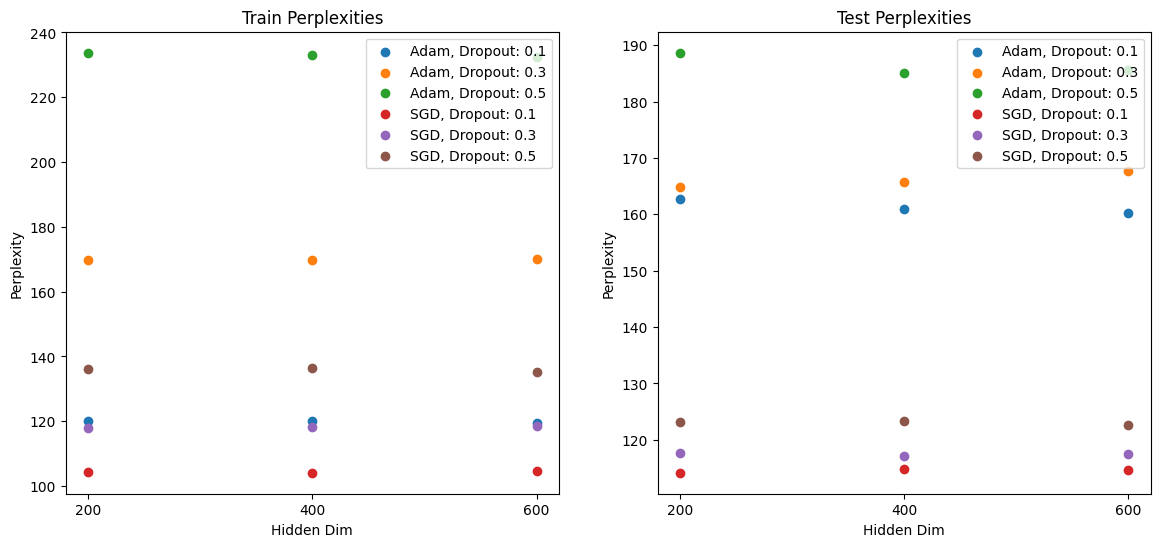

Optimal Hyperparameters: Dropout: 0.1, Hidden Dim: 200, Optimizer: SGD, Test Perplexity: 114.15992736816406


In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot train perplexities
for optimizer_name in optimizers:
    for dropout in dropout_rates:
        train_perplexities = [res[3] for res in results if res[0] == dropout and res[2] == optimizer_name]
        hidden_dims_for_optimizer = [res[1] for res in results if res[0] == dropout and res[2] == optimizer_name]
        indices = range(len(hidden_dims_for_optimizer))
        ax[0].scatter(indices, train_perplexities, label=f'{optimizer_name}, Dropout: {dropout}')

ax[0].set_title('Train Perplexities')
ax[0].set_xlabel('Hidden Dim')
ax[0].set_ylabel('Perplexity')
ax[0].set_xticks(indices)
ax[0].set_xticklabels(hidden_dims_for_optimizer)
ax[0].legend()

# Plot test perplexities
for optimizer_name in optimizers:
    for dropout in dropout_rates:
        test_perplexities = [res[4] for res in results if res[0] == dropout and res[2] == optimizer_name]
        hidden_dims_for_optimizer = [res[1] for res in results if res[0] == dropout and res[2] == optimizer_name]
        indices = range(len(hidden_dims_for_optimizer))
        ax[1].scatter(indices, test_perplexities, label=f'{optimizer_name}, Dropout: {dropout}')

ax[1].set_title('Test Perplexities')
ax[1].set_xlabel('Hidden Dim')
ax[1].set_ylabel('Perplexity')
ax[1].set_xticks(indices)
ax[1].set_xticklabels(hidden_dims_for_optimizer)
ax[1].legend()

plt.show()

optimal_hyperparams = min(results, key=lambda x: x[4])
print(f"Optimal Hyperparameters: Dropout: {optimal_hyperparams[0]}, Hidden Dim: {optimal_hyperparams[1]}, Optimizer: {optimal_hyperparams[2]}, Test Perplexity: {optimal_hyperparams[4]}")

In [4]:
file_path = "Auguste_Maquet.txt"
glove_path = "glove.6B.300d.txt"
# can use fasttext as well just by specifying the path

text_processor = TextProcessor(file_path)
sentences = text_processor.preprocess_text()

random.seed(42)
random.shuffle(sentences)

val_len = int(len(sentences) * 0.1)
test_len = int(len(sentences) * 0.2)

train_sentences = sentences[val_len + test_len:]
val_sentences = sentences[:val_len]
test_sentences = sentences[val_len:val_len + test_len]

vocabulary = Vocabulary(glove_path)
vocabulary.build_vocab(train_sentences)
embeddings = vocabulary.get_glove_embeddings()

In [6]:
print(embeddings.shape[0])

18843


In [14]:
model = NeuralLanguageModel(
    vocab_size=embeddings.shape[0], embedding_dim=embeddings.shape[1], hidden_dim=300, embedding=embeddings, dropout=0.5).to(device)
model.load_state_dict(torch.load("model.pth"))
criterion = nn.CrossEntropyLoss(reduction='mean')

In [19]:
# Function to write average perplexities of sentences to a file
def write_perplexities(model, sentences, criterion, file_path, vocabulary, device):
    with open(file_path, 'a') as f:
        for sentence in sentences:
            sentence = sentence.split()
            total_loss = 0
            count = 0
            for i in range(len(sentence) - 5):
                context = sentence[i:i + 5]
                target = sentence[i + 5]
                context = torch.tensor([vocabulary.word2index(word) for word in context]).unsqueeze(0).to(device)
                target = torch.tensor([vocabulary.word2index(target)]).to(device)
                
                # Forward pass
                output = model(context)
                
                # Reshape output and target for CrossEntropyLoss
                output = output.view(-1, output.size(-1))  # Shape: [batch_size * seq_len, vocab_size]
                target = target.view(-1)  # Shape: [batch_size * seq_len]
                
                # Calculate loss
                loss = criterion(output, target)
                # perplexity = calculate_perplexity(loss.item())
                total_loss += loss.item()
                count += 1
            
            if count > 0:
                avg_perplexity = calculate_perplexity(total_loss / count).item()
                f.write(f"Sentence: {' '.join(sentence)}\tAverage Perplexity: {avg_perplexity:.4f}\n")

write_perplexities(model, train_sentences, criterion, "LM-1-train.txt", vocabulary, device)
write_perplexities(model, val_sentences, criterion, "LM-1-val.txt", vocabulary, device)
write_perplexities(model, test_sentences, criterion, "LM-1-test.txt", vocabulary, device)
            